
######################### NURP 1010 #########################



,Facility,Counts
1,Miriam Hospital,13
2,Berkshire Place Nursing and Rehabilitation Center,7
3,Kent Hospital,5


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,17,8,68%,32%
2,Learning Outcomes,15,10,60%,40%
3,Orientation Provided,22,3,88%,12%
4,RNs as Role Models,17,8,68%,32%
5,Staff Responsibility,18,7,72%,28%
6,Record Access,22,3,88%,12%
7,Staff/Student Relationship,17,7,71%,29%
8,Facility Space,11,13,46%,54%
9,Recommend Facility,15,8,65%,35%
10,Issues Resolved with Staff,16,6,73%,27%


Miriam Hospital
Kent Hospital
Berkshire Place Nursing and Rehabilitation Center

######################### NURS 1010 #########################



,Facility,Counts
1,Rhode Island Hospital,23
2,Kent Hospital,21
3,Charlton Memorial Hospital,13
4,Cherry Hill Manor Nursing & Rehabilitation Center,12
5,Evergreen House Health Center,12
6,Landmark Medical Center,11
7,Westerly Hospital,2
8,Miriam Hospital,1


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,85,8,91%,9%
2,Learning Outcomes,84,10,89%,11%
3,Orientation Provided,90,4,96%,4%
4,RNs as Role Models,85,7,92%,8%
5,Staff Responsibility,90,4,96%,4%
6,Record Access,88,4,96%,4%
7,Staff/Student Relationship,83,9,90%,10%
8,Facility Space,78,14,85%,15%
9,Recommend Facility,83,10,89%,11%
10,Issues Resolved with Staff,81,6,93%,7%


Charlton Memorial Hospital
Rhode Island Hospital
Evergreen House Health Center
Cherry Hill Manor Nursing & Rehabilitation Center
Kent Hospital
Landmark Medical Center
Westerly Hospital
Miriam Hospital

######################### NURS 1020 #########################



,Facility,Counts
1,Kent Hospital,35
2,Miriam Hospital,21
3,Rhode Island Hospital,17
4,Landmark Medical Center,11
5,Newport Hospital,9
6,Roger William’s Medical Center,2


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,87,8,92%,8%
2,Learning Outcomes,88,7,93%,7%
3,Orientation Provided,89,6,94%,6%
4,RNs as Role Models,85,9,90%,10%
5,Staff Responsibility,89,6,94%,6%
6,Record Access,89,6,94%,6%
7,Staff/Student Relationship,81,13,86%,14%
8,Facility Space,69,22,76%,24%
9,Recommend Facility,88,7,93%,7%
10,Issues Resolved with Staff,81,4,95%,5%


Newport Hospital
Miriam Hospital
Kent Hospital
Landmark Medical Center
Rhode Island Hospital
Roger William’s Medical Center

######################### NURS 1023 #########################



,Facility,Counts
1,Rhode Island Hospital,12
2,Butler Hospital,7
3,Roger William’s Medical Center,7


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,24,1,96%,4%
2,Learning Outcomes,22,2,92%,8%
3,Orientation Provided,25,0,100%,0%
4,RNs as Role Models,20,4,83%,17%
5,Staff Responsibility,24,1,96%,4%
6,Record Access,23,3,88%,12%
7,Staff/Student Relationship,20,5,80%,20%
8,Facility Space,16,6,73%,27%
9,Recommend Facility,22,2,92%,8%
10,Issues Resolved with Staff,20,1,95%,5%


Rhode Island Hospital


<ipython-input-90-f7236a07ff8b>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


Butler Hospital
Roger William’s Medical Center

######################### NURS 2040 #########################



,Facility,Counts
1,Rhode Island Hospital,21
2,Kent Hospital,11
3,Miriam Hospital,6
4,St. Anne's Hospital,3


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,34,7,83%,17%
2,Learning Outcomes,34,7,83%,17%
3,Orientation Provided,35,6,85%,15%
4,RNs as Role Models,34,7,83%,17%
5,Staff Responsibility,34,7,83%,17%
6,Record Access,36,5,88%,12%
7,Staff/Student Relationship,32,8,80%,20%
8,Facility Space,21,15,58%,42%
9,Recommend Facility,34,7,83%,17%
10,Issues Resolved with Staff,31,5,86%,14%


Kent Hospital


<ipython-input-90-f7236a07ff8b>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


St. Anne's Hospital
Miriam Hospital
Rhode Island Hospital

######################### NURS 2050 Maternity #########################



,Facility,Counts
1,Women and Infants Hospital,9
2,Kent Hospital,6
3,Hasbro Children's Hospital,2
4,Virtual OB Clinical,1


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,12,5,71%,29%
2,Learning Outcomes,14,4,78%,22%
3,Orientation Provided,15,3,83%,17%
4,RNs as Role Models,14,3,82%,18%
5,Staff Responsibility,12,4,75%,25%
6,Record Access,14,3,82%,18%
7,Staff/Student Relationship,13,4,76%,24%
8,Facility Space,11,4,73%,27%
9,Recommend Facility,11,6,65%,35%
10,Issues Resolved with Staff,13,4,76%,24%


<ipython-input-90-f7236a07ff8b>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


Kent Hospital
Women and Infants Hospital
Hasbro Children's Hospital
Virtual OB Clinical

######################### NURS 2050 Pediatrics #########################



,Facility,Counts
1,Hasbro Children's Hospital,10
2,Kent Hospital,2
3,Rhode Island Hospital,2
4,Women and Infants Hospital,2


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,12,3,80%,20%
2,Learning Outcomes,10,5,67%,33%
3,Orientation Provided,11,4,73%,27%
4,RNs as Role Models,13,2,87%,13%
5,Staff Responsibility,12,2,86%,14%
6,Record Access,13,2,87%,13%
7,Staff/Student Relationship,12,2,86%,14%
8,Facility Space,9,5,64%,36%
9,Recommend Facility,12,3,80%,20%
10,Issues Resolved with Staff,12,2,86%,14%


<ipython-input-90-f7236a07ff8b>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


Hasbro Children's Hospital
Kent Hospital
Rhode Island Hospital
Women and Infants Hospital

######################### NURS 2060 #########################



,Facility,Counts
1,Miriam Hospital,1
2,Rhode Island Hospital,1


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,0,2,0%,100%
2,Learning Outcomes,0,2,0%,100%
3,Orientation Provided,0,2,0%,100%
4,RNs as Role Models,0,2,0%,100%
5,Staff Responsibility,0,2,0%,100%
6,Record Access,0,2,0%,100%
7,Staff/Student Relationship,0,2,0%,100%
8,Facility Space,0,2,0%,100%
9,Recommend Facility,0,2,0%,100%
10,Issues Resolved with Staff,0,2,0%,100%


<ipython-input-90-f7236a07ff8b>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


Rhode Island Hospital
Miriam Hospital

######################### NURS 2500 #########################



,Facility,Counts
1,Rhode Island Hospital,3
2,Newport Hospital,2
3,Miriam Hospital,1
4,St. Anne's Hospital,1


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,6,1,86%,14%
2,Learning Outcomes,6,1,86%,14%
3,Orientation Provided,6,1,86%,14%
4,RNs as Role Models,6,1,86%,14%
5,Staff Responsibility,6,1,86%,14%
6,Record Access,6,1,86%,14%
7,Staff/Student Relationship,6,1,86%,14%
8,Facility Space,5,2,71%,29%
9,Recommend Facility,6,1,86%,14%
10,Issues Resolved with Staff,6,1,86%,14%


Rhode Island Hospital


<ipython-input-90-f7236a07ff8b>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


Newport Hospital
St. Anne's Hospital
Miriam Hospital

######################### NURS 2500 Capstone #########################



,Facility,Counts
1,Rhode Island Hospital,25
2,Kent Hospital,10
3,Miriam Hospital,8
4,Women and Infants Hospital,4
5,Newport Hospital,1
6,St. Anne's Hospital,1


,Question,Agree,Disagree,Agree %,Disagree %
1,Patient Diversity,43,6,88%,12%
2,Learning Outcomes,43,6,88%,12%
3,Orientation Provided,44,5,90%,10%
4,RNs as Role Models,42,7,86%,14%
5,Staff Responsibility,45,4,92%,8%
6,Record Access,45,4,92%,8%
7,Staff/Student Relationship,44,5,90%,10%
8,Facility Space,38,10,79%,21%
9,Recommend Facility,44,5,90%,10%
10,Issues Resolved with Staff,43,2,96%,4%


Kent Hospital
Rhode Island Hospital


<ipython-input-90-f7236a07ff8b>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


Miriam Hospital
Newport Hospital
Women and Infants Hospital
St. Anne's Hospital


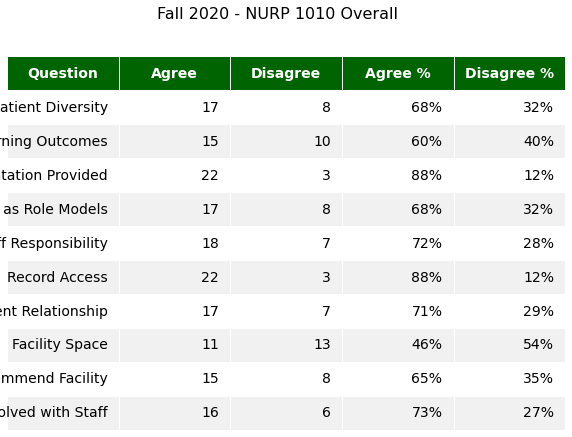

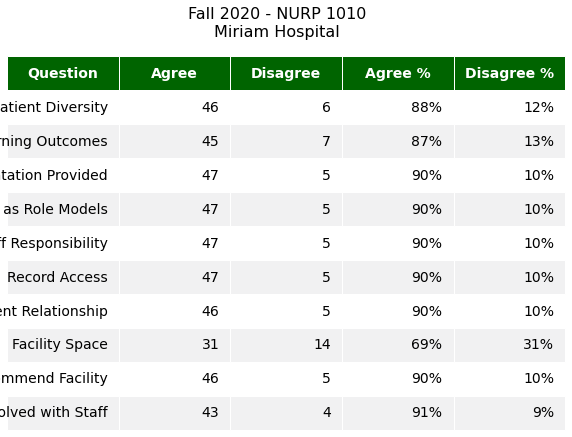

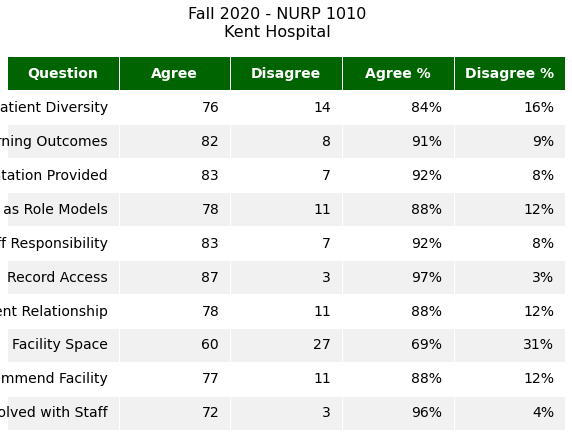

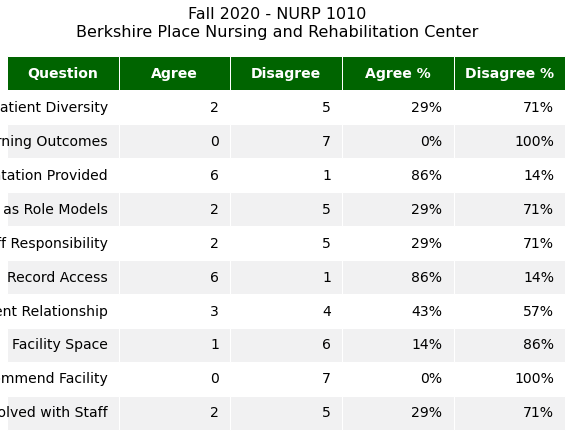

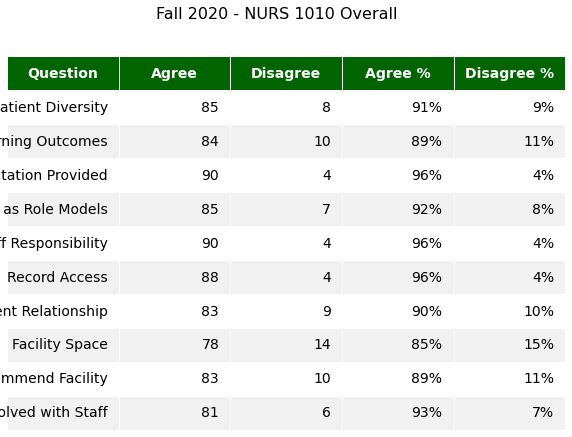

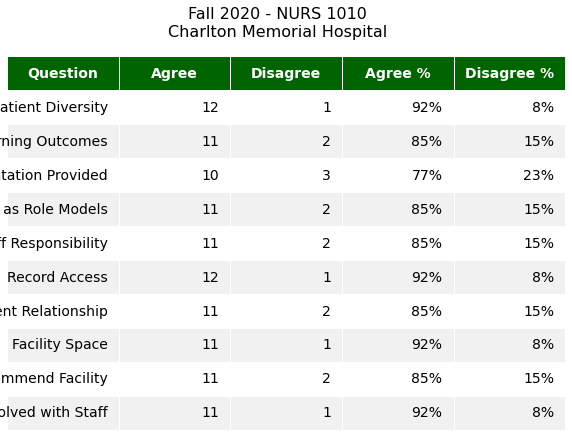

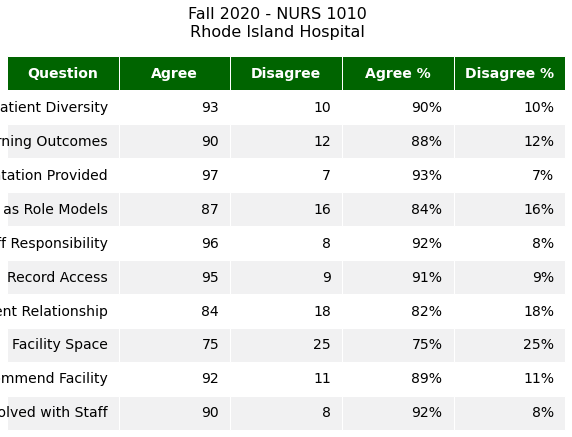

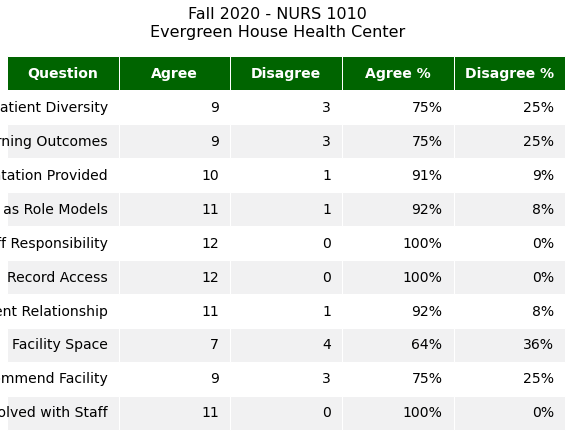

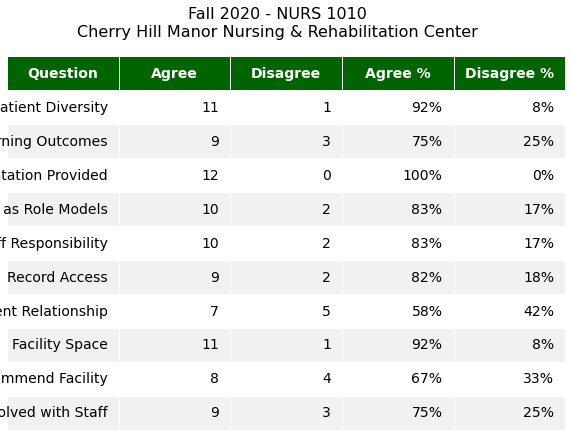

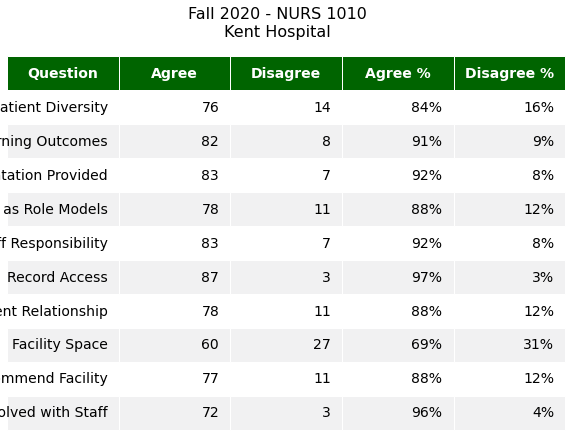

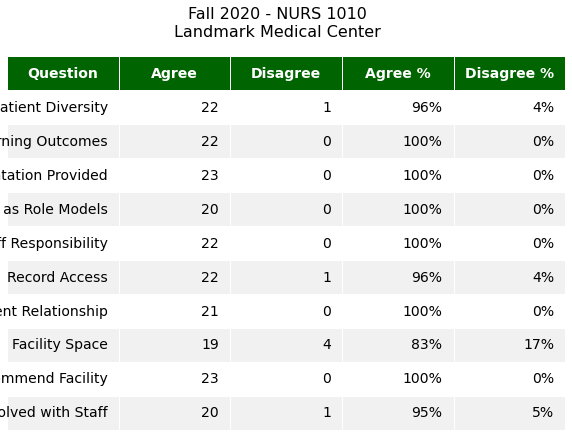

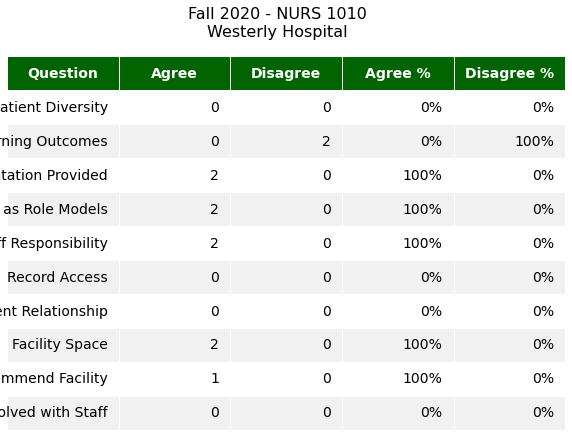

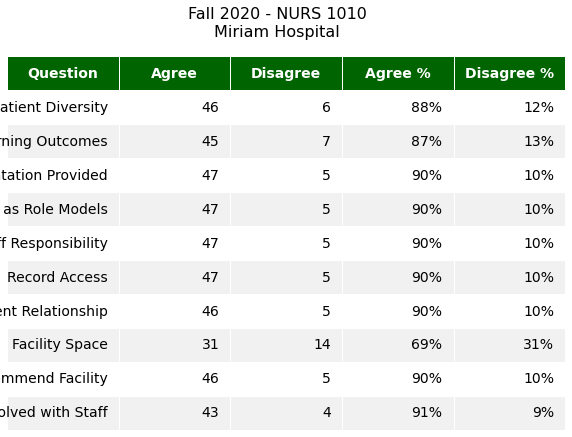

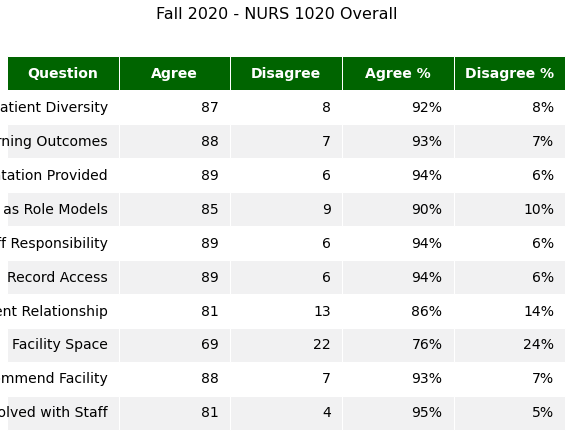

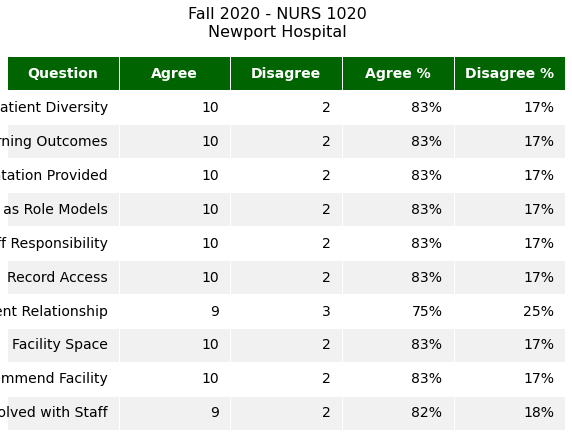

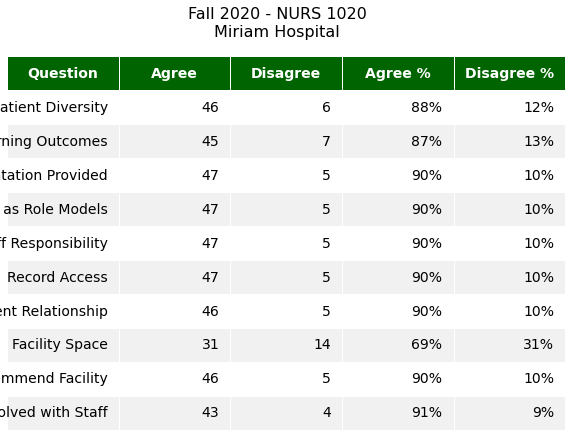

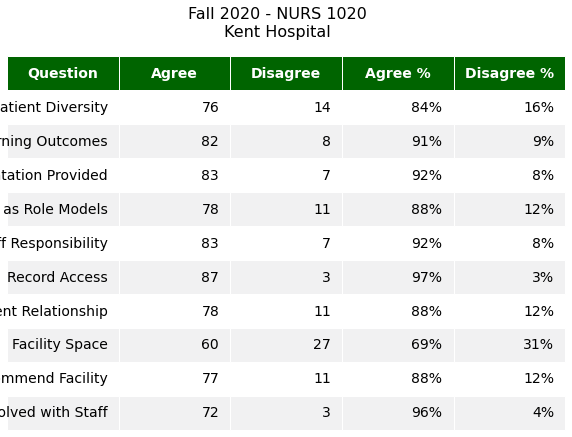

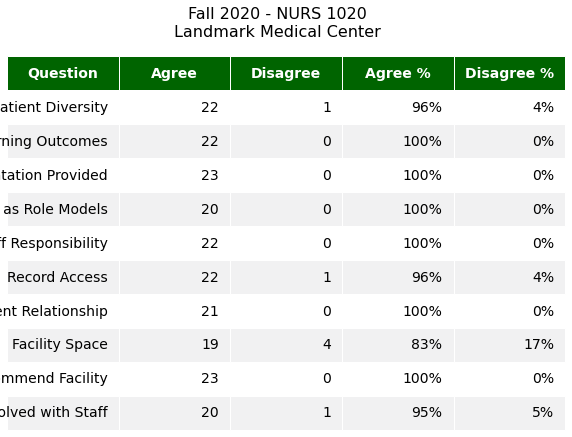

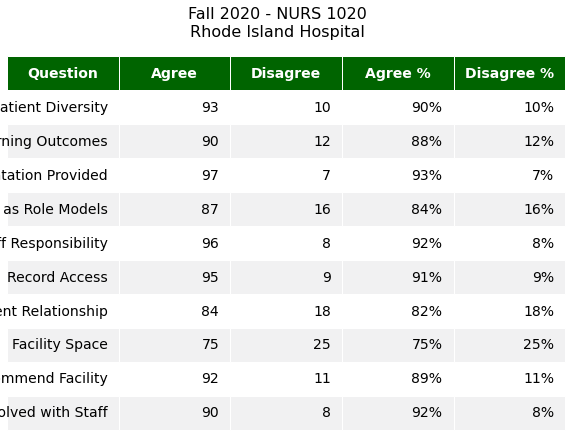

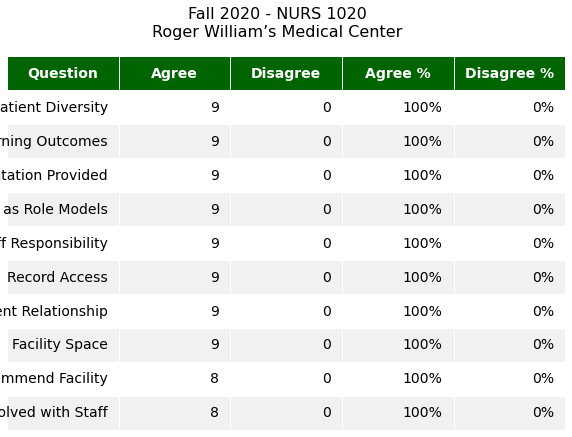

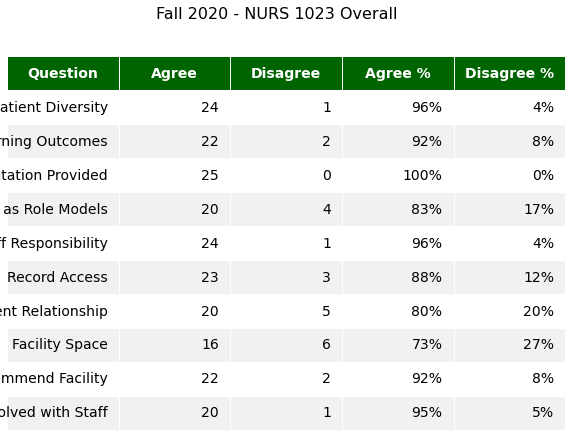

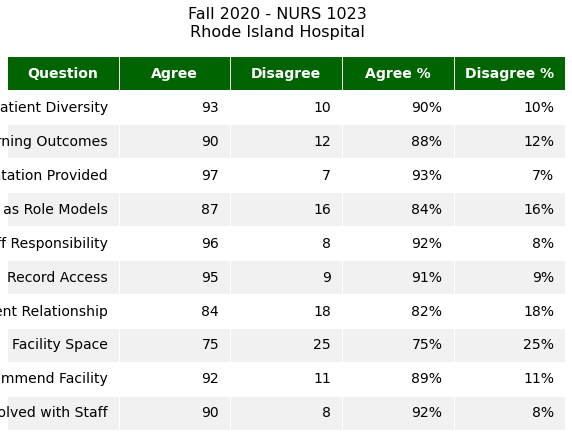

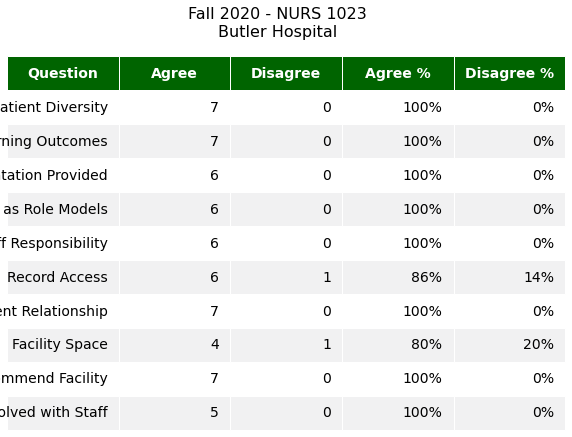

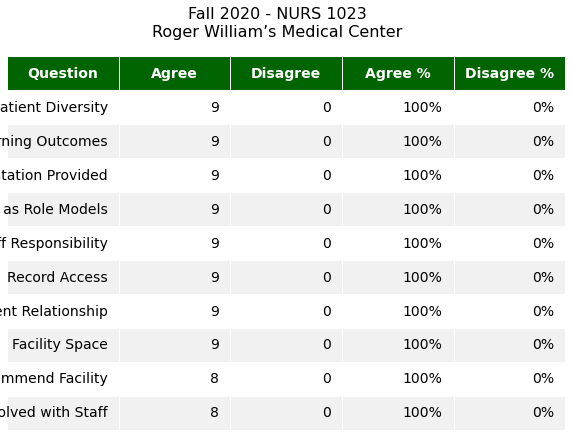

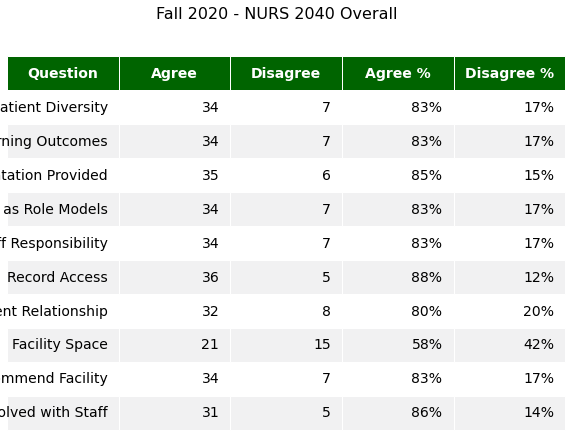

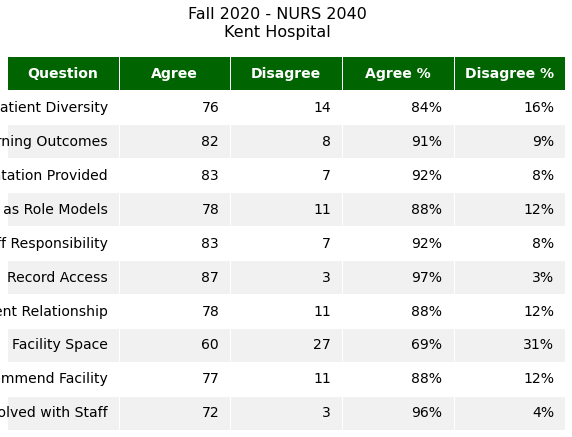

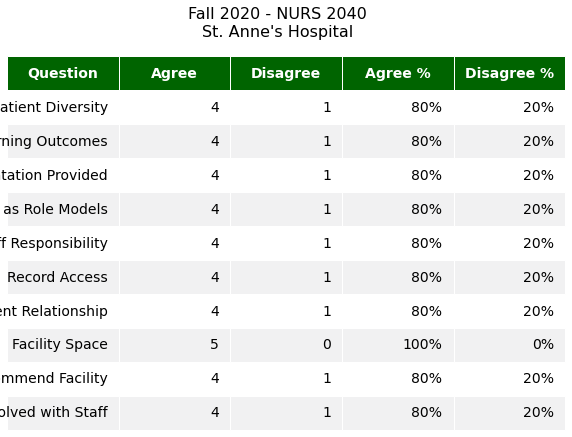

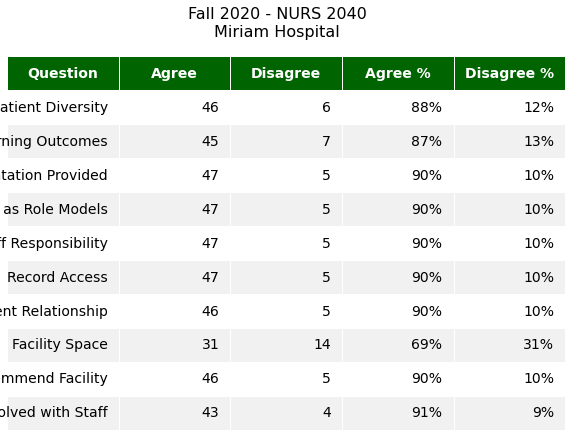

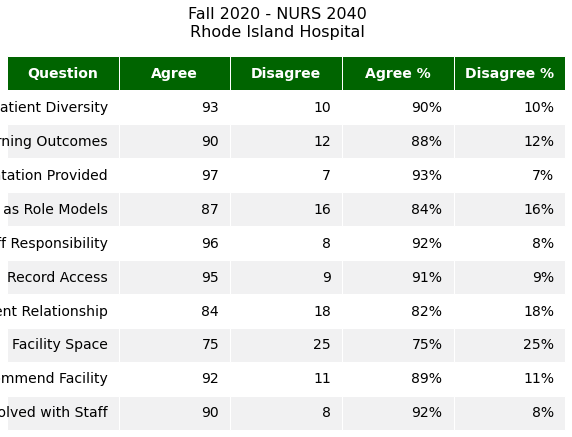

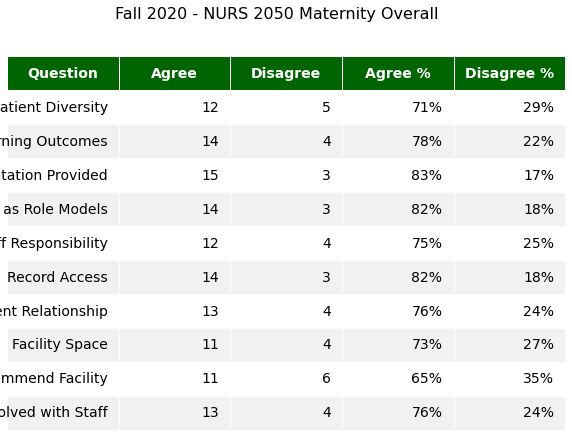

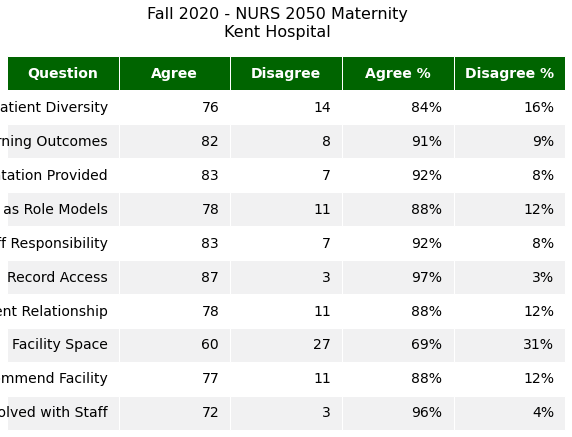

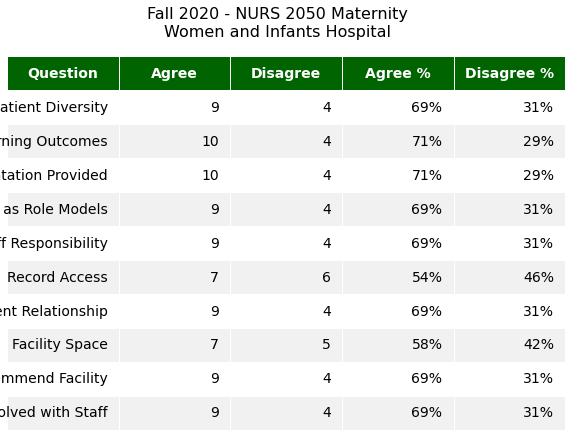

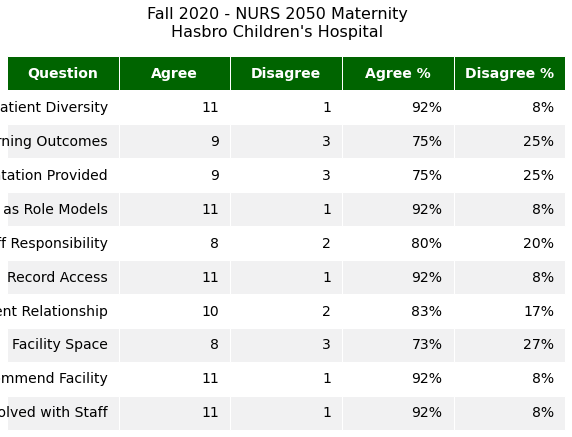

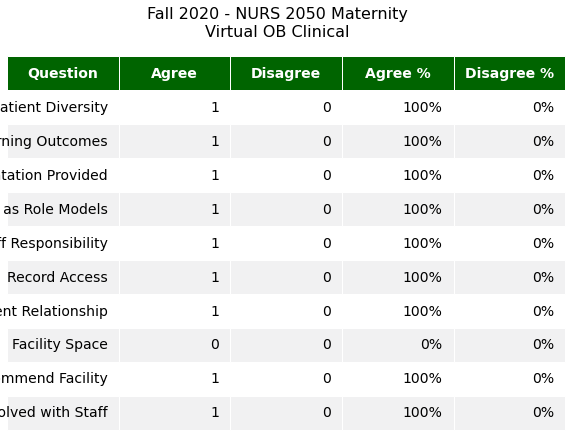

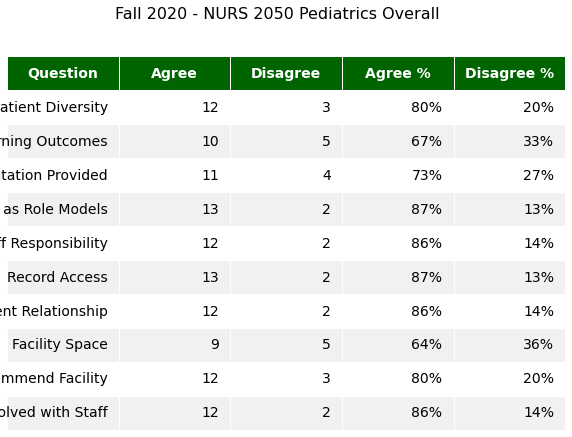

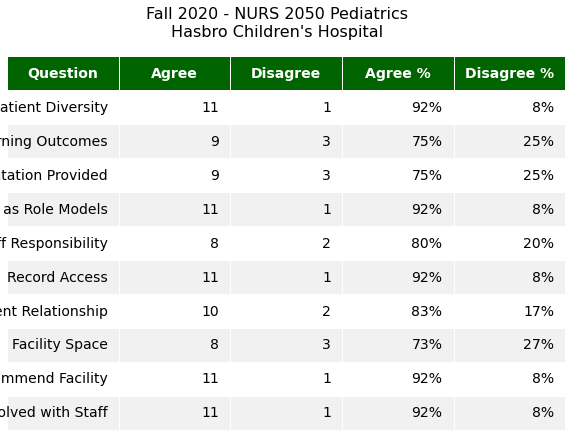

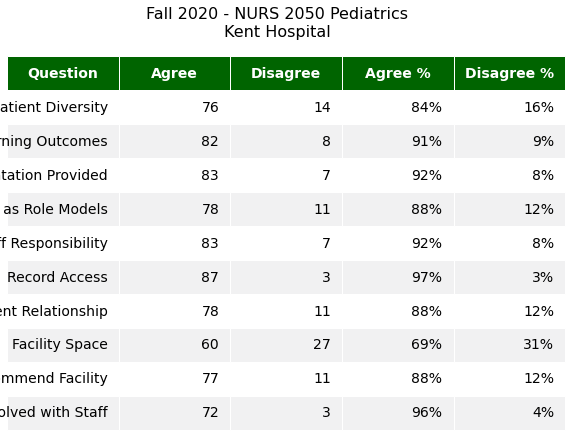

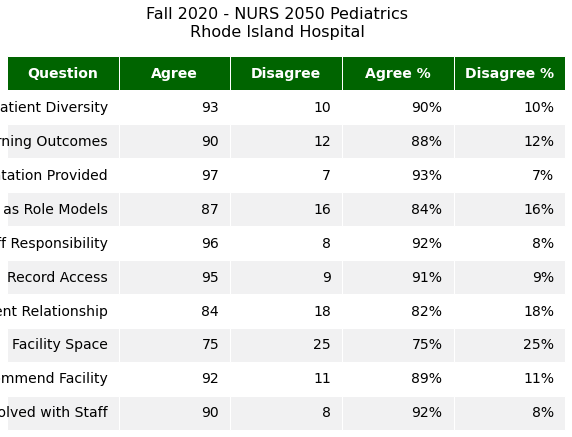

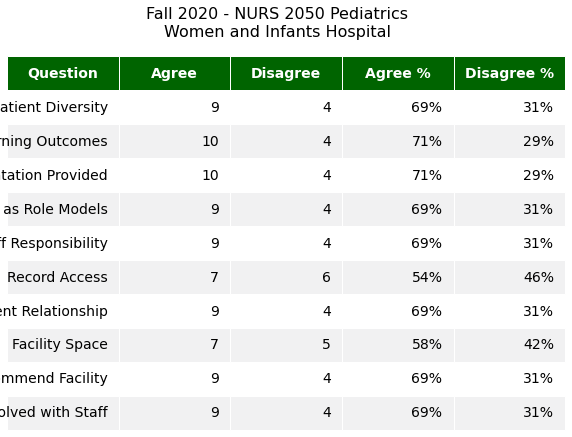

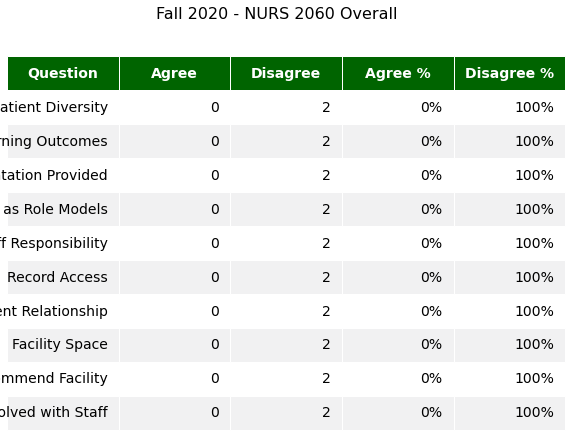

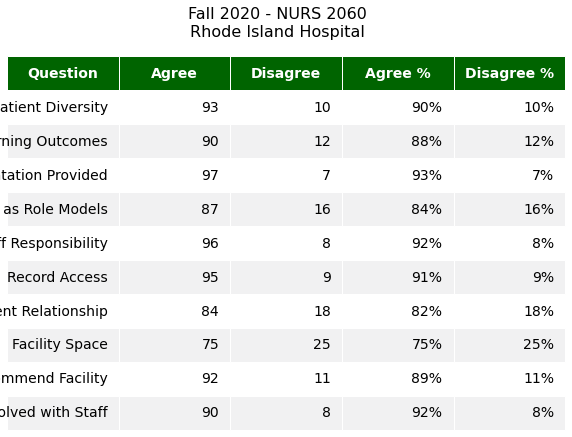

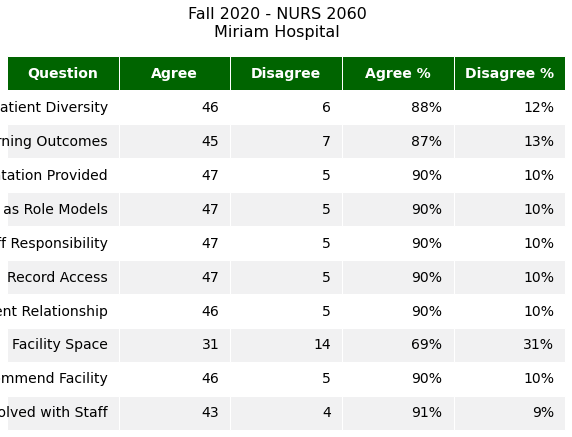

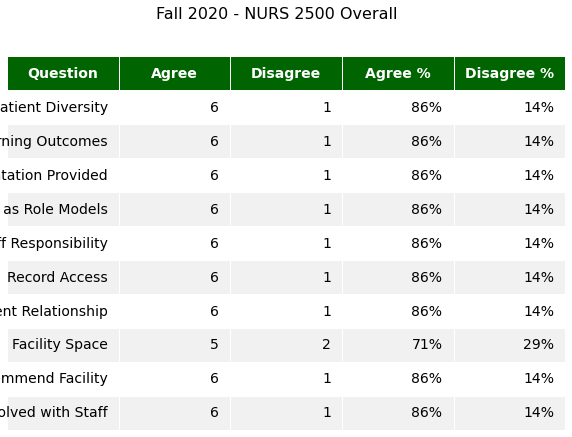

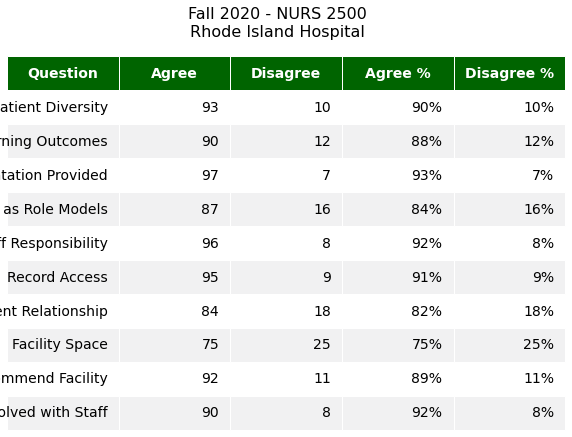

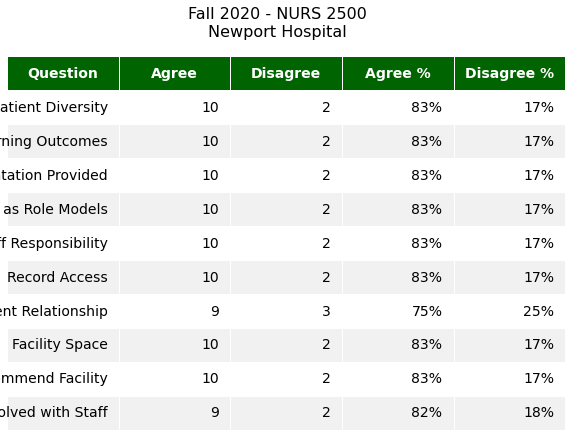

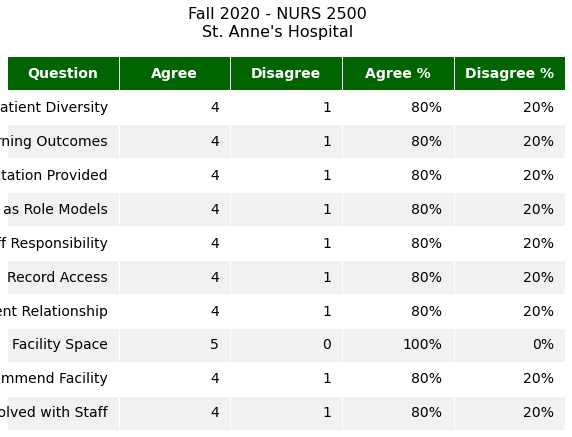

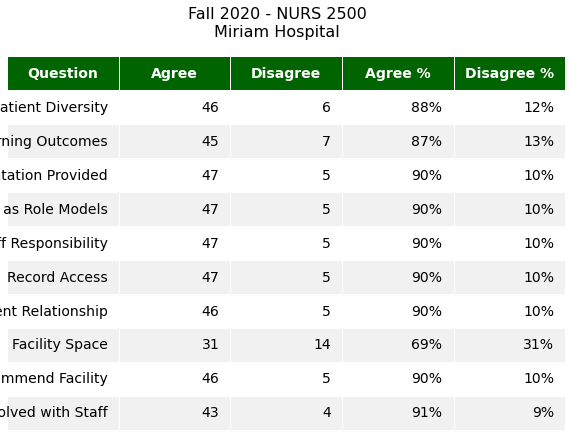

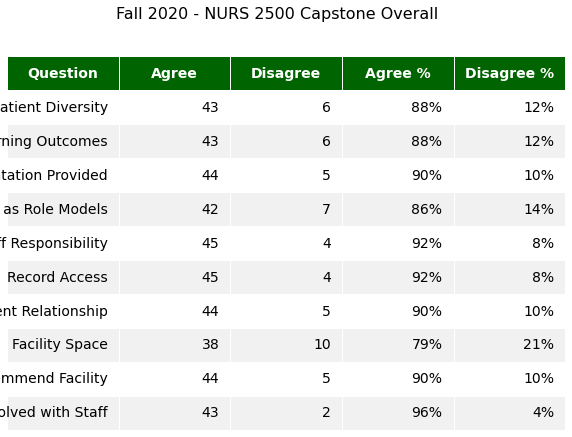

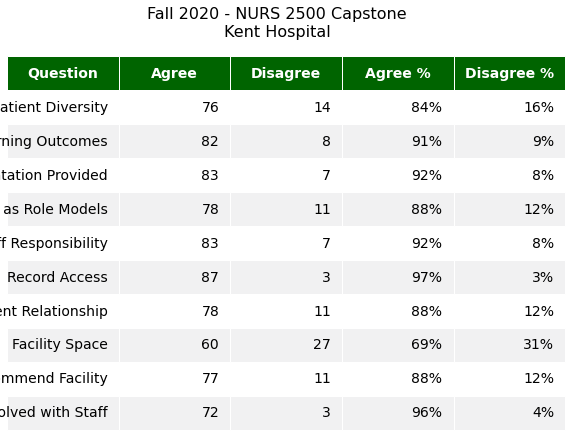

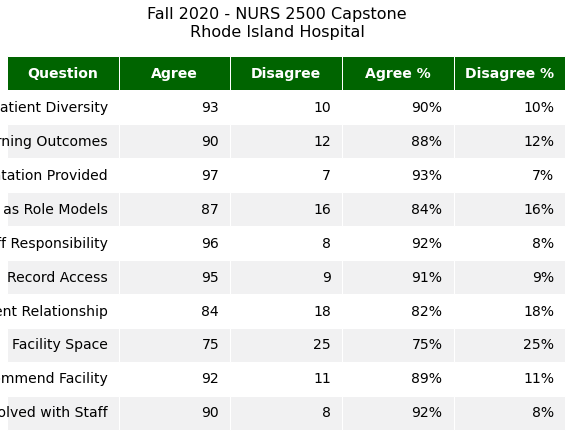

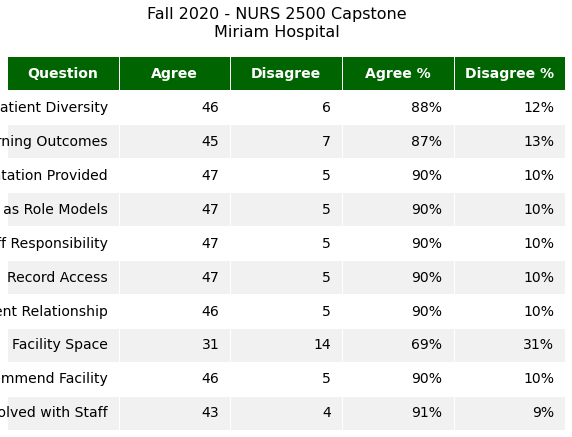

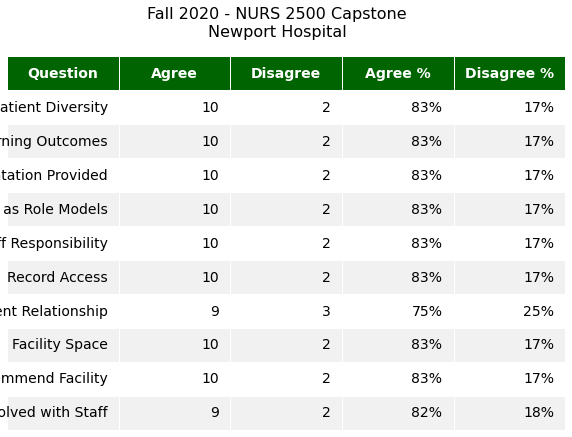

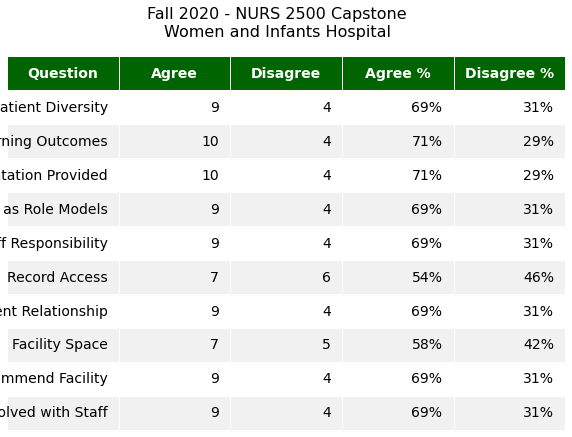

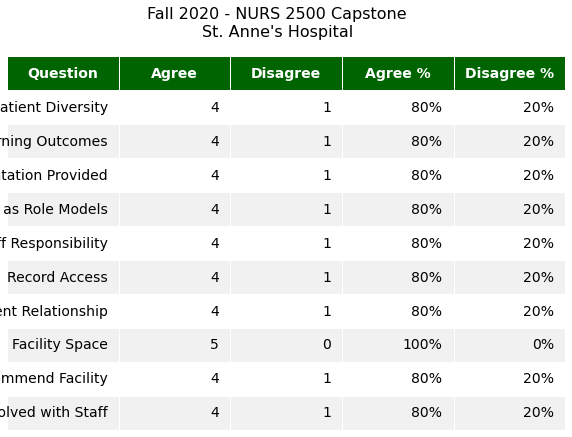

In [90]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# function name: read_as_dataframe
# argument(s): 1 string representing the name of the CSV file
# description: converts data in a CSV file to a Pandas DataFrame
# return: 1 Pandas DataFrame
def read_as_dataframe(csv_filename):
    # open csv and make dataframe
    df = pd.read_csv(csv_filename)
    return df

# function name: process_df
# argument(s):  1 string representing the file name of the data set
# description: calls the necessary functions to read the data set into a DataFrame and clean it
# return: df
def process_df(filename):
    # read and make DataFrame from csv
    df = read_as_dataframe(filename)
    return df

# function name: isolate_sem
# argument(s): 1 dataframe, 1 string representing semester
# description: isolates data by semester
# return: df by semester
def isolate_sem(df, col):
    df_iso = df[df['Semester'] == col]
    df_iso = df_iso.reset_index(drop = True)
    return df_iso

# function name: isolate_course
# argument(s): 1 dataframe, 1 string representing course title
# description: isolates data by course
# return: df by course
def isolate_course(df, col):
    df_iso = df[df['Course'] == col]
    df_iso = df_iso.reset_index(drop = True)
    return df_iso

# function name: facility_counts
# argument(s): 1 dataframe
# description: provides output of facility counts
# return: summary table with facility counts 
def facility_counts(df):
    sum_table = df.groupby('Facility').size().reset_index(name = 'Counts').sort_values(by = 'Counts', ascending = False)
    sum_table = sum_table.reset_index(drop = True)
    sum_table.index += 1
    return sum_table

# function name: facility_list
# argument(s): 1 dataframe
# description: gets list of facilities
# return: one list of facilities for that semester
def facility_list(df):
    df_unique = df['Facility'].unique()
    return df_unique

# function name: q_cts
# argument(s): 1 dataframe
# description: makes new dataframe with counts and percentages for agree/disagree for question 6
# return: 1 dataframe
def q_cts(df):
    # questions lists
    qs = ['Patient Diversity', 'Learning Outcomes', 'Orientation Provided', 'RNs as Role Models', 'Staff Responsibility', 'Record Access', 'Staff/Student Relationship', 'Facility Space', 'Recommend Facility', 'Issues Resolved with Staff']
    q_ct = []
    
    # for question column count yes and no
    for item in qs:
        agree = df[df[item] == 'Agree'].shape[0]
        disagree = df[df[item] == 'Disagree'].shape[0]
        if agree == 0 and disagree == 0:
            q_ct.append([item, agree, disagree, '0%', '0%'])
        else:
            # calculate averages
            a_per = agree/(agree+disagree)
            a_per_str = '{0:.0%}'.format(a_per)
            d_per = disagree/(agree+disagree)
            d_per_str = '{0:.0%}'.format(d_per)
            # add to dataframe
            q_ct.append([item, agree, disagree, a_per_str, d_per_str])
    
    # new dataframe
    qs_df = pd.DataFrame(columns = ['Question', 'Agree', 'Disagree', 'Agree %', 'Disagree %'], data = q_ct)
    qs_df.index += 1
    return qs_df

# convert dataframe to matplotlib table
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#006400', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

def main():
    semester = 'Fall 2020'
    filename = 'Fall_2020_Eval.csv'
    
    df = process_df(filename)
    sem_df = isolate_sem(df, semester)
    
    courses = ['NURP 1010', 'NURS 1010', 'NURS 1020', 'NURS 1023', 'NURS 2040', 'NURS 2050 Maternity', 'NURS 2050 Pediatrics', 'NURS 2060', 'NURS 2500', 'NURS 2500 Capstone']
    for x in courses:
        print ('\n######################### %s #########################\n' %x)
        course_df = isolate_course(sem_df, x)
        # show summary table of facilites for the semester
        facilities = facility_counts(course_df)
        display(facilities)
        
        #calculate general agree/disagree data
        general_cts = q_cts(course_df)
        display(general_cts)
        
        # format table
        gen_fig, gen_ax = render_mpl_table(general_cts, header_columns = 0, col_width = 2.0)
        gen_fig.suptitle('%s - %s Overall' %(semester, x), fontsize = 16)
        gen_fig.savefig('%s_%s_overall.png' %(semester, x))
        
        # generate individual facility tables
        list_of_facilities = facility_list(course_df)
        for site in list_of_facilities:
            print(site)
            facility = df[df['Facility'] == site]
            fac_cts = q_cts(facility)
            #display(fac_cts)
            
            # format table
            fig,ax = render_mpl_table(fac_cts, header_columns = 0, col_width = 2.0)
            fig.suptitle('%s - %s\n%s' %(semester, x, site), fontsize = 16)
            fig.savefig('%s_%s_%s.png' %(semester, x, site))

main()